## Cancer Stem Cell Model-- Tumor simulation
Agent model based on 

### CSC neutral model

In [208]:
import pandas as pd
import numpy as np
import random
import copy
import baltic as bt
#create classes
class Cell:
    def __init__(self):
        self.parent = None #cell it was derived from
        self.children = [] #set of daughter cells
        self.locx = None #x location in lattice
        self.locy = None #y location in lattice
        self.birthdate = None
        self.deathdate = None
        self.pmax = 10 #proliferation potential
        self.cellnum = None #unique cell number to identify
        self.alpha = 0.01 #probability of sponaneous death
        self.mutation_rate = 0.1 #probability of mutation per cell division
        self.motility = None #probability of migration per day
        self.proliferation_rate = 1 #average cell divisions per day
        self.clone = None
        self.mutations = []
        self.ps = 0
        self.curnode = None
        self.new_mut = False

class StemCell(Cell): #define stem cell class
    def __init__(self):
        Cell.__init__(self)
        self.pmax = float('inf') #infinite proliferation potential
        self.alpha = 0 #immortal
        self.ps = 0 #probability of symmetric division

# class Clone(): #define clone class
#     def __init__(self):
#         self.parent = None
#         self.children = []
#         self.birthdate = None
#         self.deathdate = None
#         self.color = None
#         self.clonenum = None
#         self.mutations = []
#         self.alive_cells = []
#         self.node = None
# class Mutation(): #definate mutation class
#     def __init__(self):
#         self.cells = []
#         self.alive_cells = []
#         self.mutnum = 'None'
        
#create lattice array
N = 10000 # starting demensions of lattice
lattice = np.empty( (N,N), dtype=object)

#parameters
proliferation_rate_CC = 2
proliferation_rate_CSC = 1
pmax_CC = 10
migration_potential = 15
alpha_CC = 0.05
cur_cellnum = 1
cur_mutnum = 0
cur_clonenum = 1
cur_index = 1
mutation_rate = 0.1

tree = bt.tree()
root = bt.node()
root.length=0 ## branch length,
root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
root.x=0## X and Y coordinates of this node, once drawTree() is called
root.alive_cells = []
tree.Objects.append(root)
tree.nodes.append(root)
tree.root = root
root.clone = 'o'

alive_cells = []
cells = []
mutations = []
clones = ['a','b','c','d']

i = int(N/2) #to place founder cell in center of lattic
modi = [0,0,1,1]
modj = [0,1,0,1]
for x in range(4):
    Fcell = StemCell() #initiate founder cell
    Fcell.locx = i+modi[x] #x location in lattice
    Fcell.locy = i+modj[x] #y location in lattice
    Fcell.birthdate = 0
    Fcell.cellnum = 0  #unique cell number to identify
    Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
    Fcell.motility = migration_potential #probability of migration per day
    Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per da
    Fcell.ps = 0.05
    Fcell.clone = clones[x]
    Fcell.curnode = root
    cells.append(Fcell)
    alive_cells.append(Fcell)
    Fcell.curnode.alive_cells.append(Fcell)

#initial founder clone object
# Fclone = Clone()
# Fclone.clone_num = 0
# Fclone.birthdate = 0
# Fcell.clone = Fclone
# Fclone.alive_cells.append(Fcell)
#Fclone.node = root

#initiate desired tracking system
#simpsons_diversity = [] #list to keep track of diversity at each time step
#clones = [] #list to contain each clone in population
#clones.append(Fclone) #add founding clone to list



#time parameters
dt = 1/float(24) # time is equilavent to 1/24 of a day or 1 hour
time = 0 #initialize time to 0
stop_time =20 #stop simulation after this many days


def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells


while time < stop_time:
    time += dt
    cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
    for cell in cell_stack:
        alive = True
        r = random.uniform(0, 1)
        pd = cell.proliferation_rate * dt #probability of proliferation in time dt
        free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
        if r < pd: # Does cell attempt to divide? 
            r = random.uniform(0,1)
            pdie = cell.alpha * pd #probability of spontaneously dying
            if r < pdie:
                alive = False
            elif len(free_cells) > 0: #is there any space to divide?
                if cell.pmax > 0: #is cell proliferation capacity exhausted?
                    r = random.uniform(0,1)
                    if r <= cell.ps: #does cell divide asymmetrically?
                        new_cell = Cell()
                        new_cell.mutation_rate = cell.mutation_rate#probability of mutation per cell division
                        new_cell.motility = cell.motility#probability of migration per day
                        new_cell.proliferation_rate = cell.proliferation_rate #average cell divisions per day
                        new_cell.clone = cell.clone
                        #new_cell.mutations = cell.mutations
                        new_cell.alpha = cell.alpha + 0.01
                    else:
                        new_cell = copy.deepcopy(cell)
                        new_cell.new_mut = False
                        #new_cell = copy.copy(cell)
                        
                    new_cell.parent = cell
                    newloc = random.choice(free_cells)
                    new_cell.locx = newloc[0] #x location in lattice
                    new_cell.locy = newloc[1] #y location in lattice
                    new_cell.birthdate = time
                    new_cell.cellnum = cur_cellnum #unique cell number to identify
                    cur_cellnum += 1
                    new_cell.children = []
                    new_cell.mutations = cell.mutations
                    new_cell.curnode = cell.curnode
                    new_cell.clone = cell.clone
                    renewed_cell = copy.deepcopy(cell)
                    renewed_cell.parent = cell
                    renewed_cell.locx = cell.locx
                    renewed_cell.locy = cell.locy
                    renewed_cell.birthdate = time
                    renewed_cell.cellnum = cur_cellnum
                    cur_cellnum += 1
                    renewed_cell.children = []
                    renewed_cell.new_mut = False
                    renewed_cell.curnode = cell.curnode
                    
                    
                    
                    
                    

                    r = random.uniform(0,1)
                    if r < cell.mutation_rate: #does cell gain a mutation?
                        #new_mut = Mutation()
                        #new_mut.mutnum = cur_mutnum
                        new_mut = cur_mutnum
                        cur_mutnum +=1
                        new_cell.mutations.append(new_mut)
                        new_cell.new_mut = True
#                         new_clone = Clone() #new mutation defines new clone group
#                         new_clone.parent = cell.clone
#                         new_clone.birthdate = time
#                         new_clone.clonenum = cur_clonenum
#                         cur_clonenum += 1
#                         new_clone.parent.children.append(new_clone) 
#                         new_clone.children.append(new_cell)
#                         new_clone.alive_cells.append(new_cell)
#                         new_cell.clone= new_clone
#                         clones.append(new_clone)
                        mutations.append(new_mut)
                        new_node = bt.node()
                        new_node.length= time - cell.curnode.x ## branch length,
                        new_node.height = time
                        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                        new_node.parent=cell.curnode ## reference to parent node of the node
                        new_node.parent.children.append(new_node)
                        new_node.index=cur_index ## index of the character designating this object
                        cur_index += 1
                        new_node.locx = cell.locx
                        new_node.locy = cell.locy
                        new_node.alive_cells = []
                        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                        new_cell.curnode = new_node
                        new_node.clone = cell.clone
                        renewed_cell.curnode = new_node
                        tree.Objects.append(new_node)
                        tree.nodes.append(new_node)
                        cell.pmax -= 1


#                     else:
#                         cell.clone.alive_cells.append(new_cell)
                        
#                     for mut in new_cell.mutations:
#                         mut.alive_cells.append(new_cell)
#                         mut.cells.append(new_cell)
                        
                    new_cell.curnode.alive_cells.append(new_cell)
                    renewed_cell.curnode.alive_cells.append(renewed_cell)
                    cell.curnode.alive_cells.remove(cell)
                    cell.children.append(renewed_cell)
                    cell.children.append(new_cell)
                    alive_cells.append(renewed_cell)
                    alive_cells.append(new_cell)
                    alive_cells.remove(cell)
                    cell.deathdate = time
                    lattice[new_cell.locx,new_cell.locy] = new_cell
                    lattice[renewed_cell.locx,renewed_cell.locy] = renewed_cell
                    cells.append(renewed_cell)
                    cells.append(new_cell)
                    new_cell.pmax -= 1 
                    renewed_cell.pmax -= 1  
                else:
                    alive = False
            elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                if len(free_cells) > 0:
                    newloc = random.choose(free_cells)
                    lattice[cell.locx,cell.locy] = 'None'
                    cell.locx = newloc[0]
                    cell.locy = newloc[1]
                    lattice[cell.locx,cell.locy] = cell
        if alive == False:
            alive_cells.remove(cell)
            cell.deathdate = time
            cell.curnode.alive_cells.remove(cell)
            if len(cell.curnode.alive_cells) == 0:
                
#             cell.clone.alive_cells.remove(cell)
#             if len(cell.clone.alive_cells) < 1:
#                 cell.clone.deathdate = time
#             if len(cell.mutations)>0:
#                 for mut in cell.mutations:
#                     mut.alive_cells.remove(cell)
#                 if len(mut.alive_cells) < 1:
#                     mutations.remove(mut)
            
                new_leaf = bt.leaf()
                new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                cur_index += 1
                new_leaf.numName = new_leaf.index
                new_leaf.length=time - cell.curnode.x ## branch length
                new_leaf.absoluteTime=time ## position of tip in absolute time
                new_leaf.parent=cell.curnode ## parent
                new_leaf.parent.children.append(new_leaf)
                new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                new_leaf.locx = cell.locx
                new_leaf.locy = cell.locy
                new_leaf.clone = cell.clone
                tree.Objects.append(new_leaf)
                tree.leaves.append(new_leaf)
                
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=stop_time - cell.curnode.x ## branch length
        new_leaf.height = stop_time
        new_leaf.absoluteTime=stop_time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = stop_time

KeyboardInterrupt: 

In [209]:
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=time - cell.curnode.x ## branch length
        new_leaf.height = time
        new_leaf.absoluteTime=time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = time

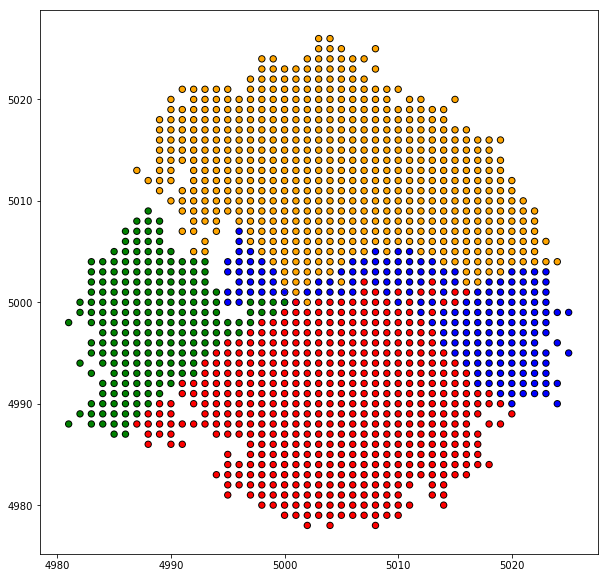

In [210]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
cmap=mpl.cm.viridis 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultation.png')
plt.show()

In [211]:
tree.traverse_tree()
tree.drawTree()

AttributeError: tree instance has no attribute 'yspan'

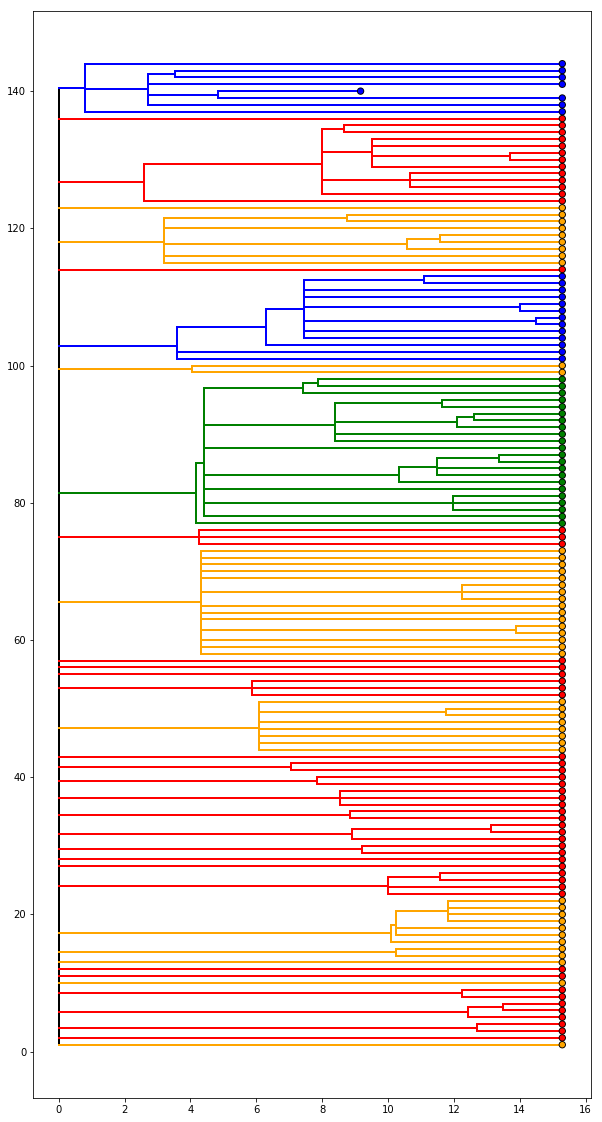

In [212]:
tree.traverse_tree()
tree.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree.yspan +5)


#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

## Clonal neutral model
Start w/ only clonal cells (no stem cells)

In [308]:
def cancer_sim(renew = True,deltat=1/float(24),CSC = True,stime = 10,proliferationCSC = 1, proliferationCC = 2, motility = 15, pmax = 10, mortality = 0.1,mutation = 0.1,selection = False):    
    import pandas as pd
    import numpy as np
    import random
    import copy
    import baltic as bt
    #create classes
    class Cell:
        def __init__(self):
            self.parent = None #cell it was derived from
            self.children = [] #set of daughter cells
            self.locx = None #x location in lattice
            self.locy = None #y location in lattice
            self.birthdate = None
            self.deathdate = None
            self.pmax = pmax #proliferation potential
            self.cellnum = None #unique cell number to identify
            self.alpha = 0.01 #probability of sponaneous death
            self.mutation_rate = mutation #probability of mutation per cell division
            self.motility = motility #probability of migration per day
            self.proliferation_rate = proliferationCC #average cell divisions per day
            self.clone = None
            self.mutations = []
            self.ps = 0
            self.curnode = None
            self.new_mut = False
            self.group = None

    class StemCell(Cell): #define stem cell class
        def __init__(self):
            Cell.__init__(self)
            self.pmax = float('inf') #infinite proliferation potential
            self.alpha = 0 #immortal
            self.ps = 0 #probability of symmetric division
            self.proliferation_rate = proliferationCSC
    
    class Group():
        def __init__(self):
            self.alive_cells = []
            self.node = None
            self.id = None


    #create lattice array
    N = 10000 # starting demensions of lattice
    lattice = np.empty( (N,N), dtype=object)

    #parameters
    proliferation_rate_CC = proliferationCC
    proliferation_rate_CSC = proliferationCSC
    pmax_CC = pmax
    migration_potential = motility
    alpha_CC = mortality
    cur_cellnum = 1
    cur_mutnum = 0
    cur_clonenum = 1
    cur_index = 1
    cur_group = 0
    mutation_rate = mutation
    time = 0

    tree = bt.tree()
    root = bt.node()
    root.length=0 ## branch length,
    root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
    root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
    root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
    root.x=0## X and Y coordinates of this node, once drawTree() is called
    root.alive_cells = []
    tree.Objects.append(root)
    tree.nodes.append(root)
    tree.root = root
    root.clone = 'o'

    alive_cells = []
    cells = []
    mutations = []
    clones = ['a','b','c','d']

    i = int(N/2) #to place founder cell in center of lattic
    modi = [0,0,1,1]
    modj = [0,1,0,1]
    if CSC == True:
        for x in range(4):
            Fcell = StemCell() #initiate founder cells, stem-cells
            Fcell.ps = 0.05
            Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per day
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = 0  #unique cell number to identify
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            Fcell.curnode = root
            cells.append(Fcell)
            alive_cells.append(Fcell)
            Fcell.curnode.alive_cells.append(Fcell)
    else:
        for x in range(4):
            Fcell = Cell() #initiate founder cells, non-stem cells
            Fcell.proliferation_rate = proliferation_rate_CC
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = 0  #unique cell number to identify
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            cells.append(Fcell)
            alive_cells.append(Fcell)
    for cell in alive_cells:
        new_node = bt.node()
        new_node.length= time - root.x ## branch length,
        new_node.height = time
        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
        new_node.parent=root ## reference to parent node of the node
        root.children.append(new_node)
        new_node.index=cur_index ## index of the character designating this object
        cur_index += 1
        new_node.locx = cell.locx
        new_node.locy = cell.locy
        new_node.alive_cells = []
        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
        cell.curnode = new_node
        new_node.clone = cell.clone
        new_node.alive_cells.append(cell)
        tree.Objects.append(new_node)
        tree.nodes.append(new_node)
        new_group = Group()
        new_group.node = new_node
        new_group.alive_cells.append(cell)
        cell.group = new_group



    #time parameters
    dt = deltat # time is equilavent to 1/24 of a day or 1 hour
    stop_time =stime#stop simulation after this many days


    def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
        free_cells = []
        change = [1,-1]
        for c in change:
            checki = lattice[i+c,j]
            if checki == None:
                free_cells.append([i+c,j])
            checkj = lattice[i, j+c]
            if checkj == None:
                free_cells.append([i,j+c])
            for h in change:
                checkd = lattice[i+h,j+c]
                if checkd == None:
                    free_cells.append([i+h,j+c])
        return free_cells
    
    while time < stop_time:
        time += dt
        cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
        print time
        for cell in cell_stack:
            alive = True
            print cell.cellnum
            r = random.uniform(0, 1)
            pd = cell.proliferation_rate * dt #probability of proliferation in time dt
            free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
            if r < pd: # Does cell attempt to divide? 
                print 'attempted divide'
                r = random.uniform(0,1)
                pdie = cell.alpha * pd #probability of spontaneously dying
                if r < pdie:
                    alive = False
                elif len(free_cells) > 0: #is there any space to divide?
                    if cell.pmax > 0: #is cell proliferation capacity exhausted?
                        r = random.uniform(0,1)
                        if r <= cell.ps: #does cell divide asymmetrically?
                            new_cell = Cell()
                            new_cell.mutation_rate = cell.mutation_rate #probability of mutation per cell division
                            new_cell.motility = cell.motility#probability of migration per day
                            new_cell.proliferation_rate = proliferation_rate_CC #average cell divisions per day
                            new_cell.clone = cell.clone
                            #new_cell.mutations = cell.mutations
                            new_cell.alpha = cell.alpha + 0.01
                            print 'asymmetric divide'
                        else:
                            #new_cell = copy.deepcopy(cell)
                            new_cell = copy.copy(cell)
                            new_cell.new_mut = False

                        new_cell.parent = cell
                        newloc = random.choice(free_cells)
                        new_cell.locx = newloc[0] #x location in lattice
                        new_cell.locy = newloc[1] #y location in lattice
                        new_cell.birthdate = time
                        new_cell.cellnum = cur_cellnum #unique cell number to identify
                        cur_cellnum += 1
                        new_cell.children = []
                        new_cell.mutations = cell.mutations
                        new_cell.curnode = cell.curnode
                        new_cell.clone = cell.clone
                        new_cell.group = cell.group
                        if renew == True:
                            renewed_cell = copy.deepcopy(cell)
                            renewed_cell.parent = cell
                            renewed_cell.locx = cell.locx
                            renewed_cell.locy = cell.locy
                            renewed_cell.birthdate = time
                            renewed_cell.cellnum = cur_cellnum
                            cur_cellnum += 1
                            renewed_cell.children = []
                            renewed_cell.new_mut = False
                            renewed_cell.curnode = cell.curnode
                            renewed_cell.group = cell.group






                        r = random.uniform(0,1)
                        if r < cell.mutation_rate: #does cell gain a mutation?
                            print 'mutated'
                            #new_mut = Mutation()
                            #new_mut.mutnum = cur_mutnum
                            new_mut = cur_mutnum
                            cur_mutnum +=1
                            new_cell.mutations.append(new_mut)
                            new_cell.new_mut = True
                            mutations.append(new_mut)
                            new_node = bt.node()
                            old_node = cell.group.node
                            new_node.length= time - old_node.x ## branch length,
                            new_node.height = time
                            new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                            new_node.parent=old_node## reference to parent node of the node
                            old_node.children.append(new_node)
                            new_node.index=cur_index ## index of the character designating this object
                            cur_index += 1
                            new_node.locx = cell.locx
                            new_node.locy = cell.locy
                            new_node.alive_cells = []
                            new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                            new_cell.curnode = new_node
                            new_node.clone = cell.clone
                            new_node2 = bt.node()
                            new_node2.length= time - old_node.x ## branch length,
                            new_node2.height = time
                            new_node2.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                            new_node2.parent=old_node## reference to parent node of the node
                            old_node.children.append(new_node2)
                            new_node2.index=cur_index ## index of the character designating this object
                            cur_index += 1
                            new_node2.locx = cell.locx
                            new_node2.locy = cell.locy
                            new_node2.alive_cells = []
                            new_node2.x=time ## X and Y coordinates of this node, once drawTree() is called
                            #cell.curnode = new_node2
                            new_node2.clone = cell.clone
                            new_group = Group()
                            new_group.node = new_node
                            new_cell.group = new_group
                            old_group = cell.group
                            old_group.node = new_node2
                            
                            
                            if renew == True:
                                renewed_cell.curnode = new_node
                            tree.Objects.append(new_node)
                            tree.nodes.append(new_node)
                            tree.Objects.append(new_node2)
                            tree.nodes.append(new_node2)
                            cell.pmax -= 1
                            new_cell.pmax -= 1


    #                     else:
    #                         cell.clone.alive_cells.append(new_cell)

    #                     for mut in new_cell.mutations:
    #                         mut.alive_cells.append(new_cell)
    #                         mut.cells.append(new_cell)

                        
                        new_cell.curnode.alive_cells.append(new_cell)
                        new_cell.group.alive_cells.append(new_cell)
                        if renew == True:
                            renewed_cell.curnode.alive_cells.append(renewed_cell)
                            cell.curnode.alive_cells.remove(cell)
                            cell.children.append(renewed_cell)
                            alive_cells.append(renewed_cell)
                            alive_cells.remove(cell)
                            lattice[renewed_cell.locx,renewed_cell.locy] = renewed_cell
                            cells.append(renewed_cell)
                            cell.deathdate = time
                            renewed_cell.pmax -= 1  
                        cell.children.append(new_cell)
                        alive_cells.append(new_cell)
                        lattice[new_cell.locx,new_cell.locy] = new_cell
                        cells.append(new_cell)
                        new_cell.pmax -= 1 
                    else:
                        alive = False
                elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                    if len(free_cells) > 0:
                        newloc = random.choose(free_cells)
                        lattice[cell.locx,cell.locy] = 'None'
                        cell.locx = newloc[0]
                        cell.locy = newloc[1]
                        lattice[cell.locx,cell.locy] = cell
            if alive == False:
                print 'died'
                alive_cells.remove(cell)
                cell.deathdate = time
                cell.curnode.alive_cells.remove(cell)
                cell.group.alive_cells.remove(cell)
                if len(cell.group.alive_cells) == 0:

                    new_leaf = bt.leaf()
                    new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                    cur_index += 1
                    new_leaf.numName = new_leaf.index
                    old_node = cell.group.node
                    new_leaf.length=time - old_node.x ## branch length
                    new_leaf.absoluteTime=time ## position of tip in absolute time
                    new_leaf.parent=old_node ## parent
                    new_leaf.old_node.append(new_leaf)
                    new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                    new_leaf.locx = cell.locx
                    new_leaf.locy = cell.locy
                    new_leaf.clone = cell.clone
                    tree.Objects.append(new_leaf)
                    tree.leaves.append(new_leaf)

    usedparents = []
    for cell in alive_cells:
        old_node = cell.group.node
        if not (cell.group.node in usedparents):
            new_leaf = bt.leaf()
            new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
            cur_index += 1
            new_leaf.length=stop_time - old_node.x ## branch length
            new_leaf.height = stop_time
            new_leaf.absoluteTime=stop_time ## position of tip in absolute time
            new_leaf.parent=old_node ## parent
            new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
            old_node.children.append(new_leaf)
            new_leaf.numName = new_leaf.index
            new_leaf.clone = cell.clone
            tree.Objects.append(new_leaf)
            tree.leaves.append(new_leaf)
            #curnode = new_leaf.parent
    #         while curnode != None:
    #             curnode.leaves.append(new_leaf)
    #             curnode = curnode.parent
            usedparents.append(old_node)


    tree.treeHeight = stop_time
    return cells, tree

In [309]:
alive_cells_CC,tree_CC = cancer_sim(stime = 10,proliferationCSC = 1,proliferationCC = 1,renew = False,CSC = True,pmax = 50,mutation = 0.1)

0.0416666666667
0
0
0
0
0.0833333333333
0
0
0
0
0.125
0
0
0
0
0.166666666667
0
0
0
0
0.208333333333
0
0
0
0
0.25
0
0
0
0
0.291666666667
0
0
0
0
0.333333333333
0
0
0
0
0.375
0
0
0
0
0.416666666667
0
0
0
0
0.458333333333
0
0
0
0
0.5
0
0
0
0
0.541666666667
0
0
0
attempted divide
0
0.583333333333
0
0
0
1
0
0.625
1
0
0
attempted divide
0
0
0.666666666667
0
0
1
2
0
0
0.708333333333
0
2
1
0
0
attempted divide
0
0.75
0
1
2
0
0
0
3
0.791666666667
0
0
0
0
3
1
2
0.833333333333
0
0
0
1
3
0
attempted divide
2
0.875
3
2
0
0
1
0
0
4
0.916666666667
3
4
2
0
0
0
1
0
0.958333333333
2
0
0
0
1
4
0
3
1.0
0
2
1
0
attempted divide
0
3
0
4
1.04166666667
0
0
1
2
5
4
0
attempted divide
3
0
1.08333333333
0
4
3
0
2
0
5
1
6
0
1.125
0
3
5
1
0
2
6
0
0
4
1.16666666667
4
0
5
3
6
0
1
0
0
2
1.20833333333
0
6
attempted divide
4
3
1
attempted divide
0
attempted divide
2
0
5
0
1.25
9
0
8
2
6
0
0
1
5
4
0
3
7
1.29166666667
0
1
0
0
attempted divide
6
2
5
7
4
8
9
0
3
1.33333333333
0
0
2
9
5
0
0
6
3
1
4
10
8
7
1.375
2
1
6
8
7
0


32
34
68
72
97
50
106
attempted divide
96
81
88
67
19
113
4.08333333333
39
6
attempted divide
54
95
79
22
0
100
56
20
5
112
97
86
82
59
69
90
71
24
32
25
102
107
110
108
61
51
36
8
attempted divide
15
96
111
40
101
74
43
26
28
94
80
1
attempted divide
85
63
45
64
23
92
98
16
49
34
52
105
118
17
50
99
11
70
attempted divide
89
93
41
47
4
68
10
attempted divide
84
91
21
78
53
87
35
attempted divide
58
75
42
30
13
attempted divide
106
3
55
67
72
33
46
0
76
115
83
62
2
116
9
60
81
77
48
31
0
66
27
103
109
14
12
114
57
7
119
18
0
73
19
88
attempted divide
117
37
44
113
65
104
29
38
4.125
51
64
115
13
101
109
104
attempted divide
89
103
113
54
1
18
85
79
117
55
46
6
5
50
97
120
110
60
63
3
91
48
52
0
0
84
96
attempted divide
9
59
19
93
70
28
24
67
86
attempted divide
77
4
62
23
10
45
61
34
14
100
102
37
38
32
40
17
105
88
74
8
92
108
82
72
81
87
68
116
44
111
98
76
27
15
106
20
21
53
65
0
31
78
114
90
7
80
57
29
73
16
118
71
25
99
36
47
22
66
26
2
83
107
119
95
42
attempted divide
56
75
112


40
87
86
82
112
27
43
131
109
64
6
152
attempted divide
147
29
0
132
34
45
70
126
166
10
98
91
110
59
161
128
149
9
167
93
101
107
58
0
154
54
89
142
125
2
156
38
attempted divide
159
134
117
153
32
168
103
35
90
30
165
84
80
138
50
39
102
169
17
95
28
56
13
92
164
41
81
163
108
94
22
63
20
158
26
74
attempted divide
127
67
21
116
73
118
96
75
5.04166666667
29
172
38
39
41
31
145
134
53
141
26
35
131
117
79
113
15
2
151
148
137
91
125
103
66
167
27
154
116
69
10
100
85
105
56
11
57
142
64
147
4
13
attempted divide
144
120
51
21
7
8
24
55
149
0
166
111
52
58
135
126
129
128
attempted divide
156
37
98
19
83
50
45
169
163
87
102
90
99
130
47
3
17
115
68
20
48
95
44
80
170
101
63
6
139
86
65
attempted divide
1
107
60
43
143
54
59
123
124
132
104
109
36
14
81
112
25
88
84
173
106
attempted divide
9
22
77
73
23
78
168
114
161
40
162
122
140
108
0
0
138
165
97
61
89
150
119
96
32
157
0
171
121
133
127
42
71
70
94
34
5
136
155
93
152
118
160
12
62
72
18
92
110
67
82
30
16
76
74
159
49
158
75
3

73
attempted divide
92
104
168
123
189
48
122
119
159
85
attempted divide
4
84
attempted divide
25
18
attempted divide
152
attempted divide
40
83
162
34
103
106
attempted divide
188
133
93
44
138
62
125
20
221
36
174
82
197
77
194
75
120
218
158
24
76
30
200
112
223
19
96
50
150
178
124
177
185
95
209
86
2
54
157
136
71
43
226
99
attempted divide
222
229
191
143
13
118
69
206
5.70833333333
25
169
141
230
28
66
85
165
58
89
100
140
36
118
214
206
142
132
26
208
6
136
166
210
71
203
33
59
attempted divide
154
119
111
22
attempted divide
40
2
174
30
18
attempted divide
44
228
225
80
153
41
226
200
attempted divide
150
146
31
0
182
164
176
196
215
209
5
229
204
173
87
144
112
49
167
50
114
64
135
55
192
47
1
68
131
61
54
194
69
94
219
108
78
177
86
32
198
attempted divide
mutated
137
15
84
7
126
232
35
227
13
223
170
155
57
188
122
46
73
130
27
17
191
190
24
216
70
163
224
101
attempted divide
104
16
113
184
98
120
201
161
99
158
147
127
125
116
121
152
212
117
93
67
43
168
11
195
29
186
6

40
137
119
48
220
135
61
244
attempted divide
167
43
249
123
6.25
155
59
189
48
20
29
109
163
73
164
179
71
145
24
attempted divide
224
108
120
19
118
141
256
160
130
17
attempted divide
23
97
78
41
255
201
attempted divide
171
40
217
233
186
193
44
165
85
35
63
12
174
2
13
149
253
52
209
30
79
257
126
184
241
249
68
152
251
54
250
121
113
7
82
226
55
66
203
attempted divide
134
221
211
15
247
81
238
167
16
147
27
182
246
0
attempted divide
65
53
239
56
25
194
151
199
157
102
204
101
10
0
146
103
98
114
72
252
133
9
266
42
197
attempted divide
mutated
232
51
37
64
87
236
225
99
107
153
18
122
43
21
88
46
220
185
attempted divide
170
119
214
230
105
100
127
168
75
212
6
14
80
248
227
33
229
222
258
132
140
86
210
208
198
206
200
104
144
57
178
213
181
attempted divide
219
26
123
31
8
67
39
69
36
243
262
22
attempted divide
70
183
254
32
216
95
77
223
235
142
264
112
117
92
47
34
94
attempted divide
231
49
176
60
125
202
61
0
attempted divide
74
161
162
172
attempted divide
207
196
215
9

197
134
215
81
61
250
251
236
196
279
133
249
303
109
166
55
0
attempted divide
67
47
269
293
270
176
38
311
28
245
182
299
attempted divide
254
127
138
145
96
131
140
217
102
224
63
88
247
137
300
64
53
144
16
256
26
289
222
180
192
36
188
30
211
207
200
73
191
43
220
294
305
69
6
242
45
275
290
60
115
273
155
106
292
296
307
255
189
225
18
132
264
111
278
attempted divide
77
75
219
10
170
65
150
21
108
147
194
315
232
85
227
attempted divide
46
12
160
0
139
212
162
186
187
246
313
272
226
213
233
4
301
14
161
22
25
118
199
5
175
172
42
70
124
100
104
244
94
259
208
240
9
34
143
146
82
0
179
29
117
156
209
154
103
295
164
195
202
50
attempted divide
152
231
84
171
24
129
110
122
49
13
2
116
151
266
71
113
20
274
165
44
83
90
287
93
92
23
15
268
235
105
309
282
158
265
230
119
148
312
184
80
168
149
314
177
86
54
66
201
128
99
280
52
205
33
283
248
79
56
263
214
304
308
41
271
185
286
125
58
167
258
190
157
262
298
120
89
51
288
97
203
178
76
252
95
114
attempted divide
19
228
221
193


299
343
220
337
188
214
0
68
283
221
271
70
353
238
181
173
attempted divide
82
153
79
356
255
8
215
19
35
54
136
40
263
53
attempted divide
57
83
59
67
335
123
338
230
3
attempted divide
354
309
66
198
236
133
139
attempted divide
284
210
80
325
241
316
93
162
127
303
attempted divide
190
156
311
308
150
186
0
342
222
128
143
183
29
97
351
251
28
229
340
270
31
194
276
56
260
116
122
187
85
152
37
208
313
234
121
114
339
74
347
307
332
81
349
attempted divide
297
39
58
245
320
13
98
262
286
148
331
0
333
189
42
103
89
92
247
261
34
242
113
52
120
134
256
179
96
257
49
126
246
141
324
91
117
223
201
109
125
attempted divide
107
195
355
360
218
155
attempted divide
84
254
6
274
350
289
86
281
272
attempted divide
mutated
24
206
327
185
2
304
204
280
273
21
318
163
170
7
100
attempted divide
265
106
61
attempted divide
180
169
attempted divide
4
282
182
171
184
108
192
77
160
140
348
131
47
200
174
149
75
164
226
228
105
63
239
attempted divide
142
279
32
322
99
attempted divide
55
321
2

132
128
362
345
255
11
104
77
292
329
48
28
176
308
attempted divide
184
199
133
290
234
354
220
4
321
370
207
335
179
280
243
340
162
262
367
222
257
361
attempted divide
5
365
139
22
249
235
231
236
123
341
350
148
105
237
37
388
153
333
120
204
130
49
9
150
339
239
113
14
74
154
25
141
306
62
attempted divide
32
334
265
293
386
114
312
376
121
283
379
65
attempted divide
96
248
326
224
attempted divide
322
353
281
284
64
140
270
210
95
286
212
51
181
208
201
323
325
192
103
60
158
156
100
1
169
151
24
313
129
277
256
299
attempted divide
3
84
357
196
272
178
317
274
352
186
182
278
2
170
86
12
183
302
338
287
40
211
122
209
109
232
93
258
attempted divide
7.45833333333
397
12
328
206
155
130
70
157
193
359
337
126
115
attempted divide
300
124
attempted divide
185
89
120
3
143
129
278
295
159
attempted divide
114
312
259
240
360
248
292
84
19
181
344
202
45
191
81
2
140
141
attempted divide
391
22
105
87
111
125
349
189
attempted divide
338
318
361
374
313
98
62
46
attempted divide
4

199
attempted divide
410
193
212
0
79
223
161
51
306
403
81
118
80
140
139
10
207
attempted divide
343
413
276
275
77
5
208
342
94
12
317
278
157
160
181
304
293
421
214
218
236
91
382
174
47
377
155
279
266
241
431
274
49
123
289
attempted divide
238
173
89
313
30
29
376
66
331
109
359
347
143
380
32
226
284
235
246
397
367
340
attempted divide
338
23
222
114
260
145
368
17
302
83
234
417
45
121
262
307
387
349
136
220
402
409
328
attempted divide
122
399
92
46
44
225
153
111
57
198
290
0
296
321
314
411
156
285
324
48
20
16
115
303
308
240
247
422
415
50
375
426
63
21
142
282
168
0
242
398
416
261
336
316
265
323
183
312
379
420
248
182
283
169
255
408
309
25
280
433
129
37
113
148
75
318
144
369
85
137
159
119
210
95
9
26
295
400
116
188
259
78
64
attempted divide
82
202
215
363
22
273
244
330
69
268
120
394
135
364
389
216
327
407
11
7.79166666667
129
112
248
435
9
20
257
145
296
160
132
162
156
72
125
attempted divide
200
391
278
203
130
398
370
153
389
attempted divide
asymmetric

81
173
370
168
422
386
458
389
332
438
196
25
300
390
129
191
407
410
137
90
312
406
238
387
224
139
134
430
392
59
249
404
382
144
79
154
32
257
attempted divide
102
456
9
365
117
296
131
attempted divide
217
466
10
192
91
187
251
424
428
444
183
78
116
432
418
269
8.08333333333
250
358
436
390
128
194
84
67
228
32
193
381
111
24
332
442
109
197
126
227
463
317
444
175
263
471
37
394
294
114
273
81
79
20
481
162
411
64
99
296
305
127
42
attempted divide
249
104
293
50
65
220
25
221
105
278
320
341
387
424
318
12
451
235
300
201
0
380
48
134
23
14
443
152
206
291
231
267
148
238
343
217
457
456
170
392
301
384
330
222
344
88
71
169
53
138
257
426
366
460
142
213
262
181
attempted divide
355
321
87
439
404
160
101
309
247
17
406
240
303
29
388
323
284
107
225
286
78
171
68
77
302
151
119
272
47
281
315
398
419
226
259
35
429
115
448
5
189
253
133
350
0
75
248
401
208
371
472
242
461
164
465
266
61
207
191
437
359
157
376
458
11
56
198
312
416
314
280
96
473
74
229
attempted divide
76
12

230
181
335
411
480
97
404
398
318
179
429
130
80
185
513
69
484
55
422
322
391
504
40
352
272
183
204
220
353
409
400
4
268
131
337
368
35
174
92
107
308
445
386
252
23
0
191
194
372
59
178
210
110
462
416
384
32
197
375
101
340
297
216
497
116
202
158
369
184
attempted divide
150
256
382
0
236
125
304
390
75
246
195
425
495
341
466
123
385
3
103
229
339
151
489
283
198
483
41
399
303
435
186
126
479
299
188
64
115
208
496
102
77
0
124
129
346
468
27
250
287
442
437
342
290
457
196
94
365
345
490
153
113
189
0
213
144
438
240
attempted divide
180
349
306
282
142
388
51
333
187
364
attempted divide
474
507
264
330
350
389
attempted divide
48
234
511
477
245
166
357
373
260
57
278
393
29
228
60
117
171
231
492
66
263
321
68
127
285
26
374
19
455
274
488
514
356
288
78
503
140
1
182
14
295
85
493
199
242
167
attempted divide
458
498
418
20
461
476
136
377
426
106
494
162
325
170
387
328
9
239
432
327
34
316
8.375
355
403
192
54
340
406
93
204
512
291
attempted divide
13
169
441
343
233
4

24
369
540
436
271
477
530
114
177
81
97
209
228
297
94
382
512
386
146
291
278
134
526
240
238
402
305
321
8
518
420
332
289
51
207
479
373
172
171
432
141
546
166
469
200
227
350
252
149
46
430
397
366
111
113
343
78
142
425
attempted divide
492
457
82
285
308
400
57
353
179
237
147
201
444
268
246
92
70
272
17
64
378
216
163
231
290
541
239
428
241
49
233
543
509
attempted divide
542
511
161
73
151
144
244
212
483
204
466
attempted divide
330
474
360
362
379
368
11
222
248
303
346
427
213
533
403
451
307
198
354
532
243
468
262
348
174
498
4
attempted divide
434
462
302
267
attempted divide
337
545
8.625
103
324
515
156
14
533
444
417
130
181
276
434
527
64
461
33
96
59
465
182
264
354
169
314
280
62
42
519
284
66
218
362
330
288
91
142
285
23
attempted divide
486
361
106
257
137
305
164
76
0
521
79
45
406
358
240
228
39
337
278
495
74
451
505
297
523
381
472
541
128
384
attempted divide
170
455
433
416
352
195
188
397
484
546
54
190
171
167
544
68
268
230
234
272
490
246
392
attemp

261
358
78
423
580
362
136
272
attempted divide
316
0
153
473
496
61
346
120
582
412
486
544
attempted divide
58
226
295
382
280
393
229
413
11
483
409
461
559
6
26
353
572
420
241
95
211
291
146
432
436
240
2
31
322
121
135
98
512
537
162
529
523
184
555
208
570
178
206
17
448
328
557
117
255
334
205
134
427
107
119
234
476
250
142
428
47
405
281
391
294
attempted divide
457
408
215
40
463
148
156
249
403
8
74
137
187
466
157
76
489
522
542
547
34
519
126
173
attempted divide
248
349
102
192
411
503
536
289
388
122
415
298
315
554
66
67
574
406
29
395
509
227
399
42
216
375
562
199
144
269
48
238
495
518
123
56
254
179
132
474
286
384
482
83
92
12
390
310
27
attempted divide
190
314
416
502
532
318
471
149
313
317
302
381
attempted divide
541
171
35
0
181
333
430
53
404
284
521
175
445
88
364
323
165
276
407
18
377
230
267
501
327
264
243
386
70
163
7
575
124
459
470
109
376
275
306
77
217
498
425
511
63
222
33
110
59
189
265
attempted divide
548
444
479
101
160
561
attempted divide
m

493
118
415
509
209
480
298
269
599
408
495
232
234
554
476
32
385
436
342
299
173
attempted divide
543
381
374
333
362
41
581
198
409
16
380
236
95
attempted divide
297
483
517
304
593
597
570
479
541
44
403
429
433
578
119
321
4
203
152
252
256
579
383
238
284
37
20
515
100
262
370
318
10
450
588
283
148
438
78
142
313
126
227
23
430
498
586
532
452
454
158
66
406
317
282
200
347
132
561
514
122
222
30
556
352
549
219
94
421
161
522
attempted divide
446
attempted divide
163
attempted divide
410
attempted divide
125
102
57
506
191
345
521
447
510
505
251
424
120
258
7
attempted divide
186
237
276
199
539
36
71
388
216
147
146
594
523
356
76
580
9.04166666667
152
433
543
398
50
567
58
11
174
205
508
233
187
231
232
501
529
558
516
491
368
418
341
9
318
528
92
421
343
464
299
361
316
72
28
564
121
262
396
253
321
44
169
249
74
413
attempted divide
556
281
255
207
100
236
456
146
441
590
161
5
436
176
112
329
308
29
215
33
304
128
332
533
378
34
59
78
599
194
18
10
242
293
356
448
406
at

486
262
53
78
462
495
129
98
596
461
578
409
342
453
149
527
114
146
118
365
64
504
435
469
128
attempted divide
373
313
550
122
301
534
478
228
292
408
470
509
103
349
338
610
209
608
416
280
254
176
71
423
494
354
235
562
177
549
490
520
351
76
377
576
2
55
16
413
125
attempted divide
473
47
581
201
0
497
399
507
240
361
366
297
496
133
230
632
434
334
172
564
310
214
267
541
143
465
528
326
182
454
171
333
589
336
attempted divide
552
274
582
441
259
131
70
215
61
81
147
340
321
619
196
93
363
392
229
attempted divide
616
153
231
390
322
281
137
443
109
200
460
529
418
48
207
217
425
205
186
15
568
506
284
572
140
515
112
20
attempted divide
181
612
213
567
84
308
13
51
attempted divide
286
471
67
151
522
491
255
279
475
237
257
524
120
94
9
426
484
362
304
277
303
291
attempted divide
30
253
502
156
295
513
77
450
44
468
50
420
309
290
104
615
246
175
141
508
479
614
594
566
438
341
10
1
433
448
533
144
498
585
145
22
221
311
374
488
324
142
75
397
158
82
601
569
attempted divide
2

431
129
attempted divide
103
98
260
27
296
77
attempted divide
325
attempted divide
479
528
341
attempted divide
68
472
0
429
220
339
116
63
244
150
283
173
448
attempted divide
640
587
518
187
24
298
247
329
83
attempted divide
55
563
396
316
241
201
203
172
560
300
122
59
87
attempted divide
225
76
123
109
293
312
80
308
393
132
31
319
42
226
240
attempted divide
556
337
330
397
141
attempted divide
20
506
575
568
5
369
580
357
471
349
566
469
442
620
112
517
131
569
91
223
255
426
558
165
106
186
120
475
547
21
382
385
336
459
498
275
117
79
332
632
462
199
343
373
attempted divide
279
410
579
501
157
313
309
159
32
359
16
372
458
513
184
578
295
attempted divide
468
533
311
523
49
54
258
398
368
390
96
95
326
attempted divide
268
624
285
263
93
573
127
attempted divide
529
414
646
97
478
383
attempted divide
524
645
243
215
623
608
637
553
344
169
520
619
551
612
509
242
160
559
621
439
355
104
124
413
447
425
477
6
321
574
522
94
496
484
474
0
66
534
81
328
297
289
111
617
395
473

133
365
498
144
508
317
595
40
129
514
505
542
387
323
347
326
315
652
319
135
225
359
55
434
244
540
165
250
143
246
306
166
403
2
656
628
157
350
102
185
407
516
286
15
586
88
524
22
240
217
210
132
604
402
363
535
199
92
179
308
211
136
353
42
226
346
453
478
629
142
301
422
170
186
79
582
473
477
543
607
44
attempted divide
148
419
203
324
38
282
603
attempted divide
381
99
8
432
507
605
442
156
565
254
551
441
112
292
160
227
189
457
190
609
433
380
438
attempted divide
214
372
661
9.58333333333
646
268
68
144
349
652
123
389
439
118
318
549
352
138
89
317
129
105
424
359
32
attempted divide
83
429
130
280
88
289
610
213
96
146
292
663
470
262
276
418
200
481
211
494
154
657
20
attempted divide
39
121
469
353
295
145
544
56
635
550
503
460
137
55
369
189
300
474
531
91
500
452
521
626
21
450
265
235
122
587
379
44
420
272
14
attempted divide
79
175
404
197
664
465
29
330
attempted divide
511
595
307
194
161
178
608
310
13
574
524
150
156
282
18
478
547
322
571
528
117
73
320
515
2

633
375
592
156
639
644
34
307
81
250
271
451
296
298
190
333
506
49
162
345
494
attempted divide
71
578
356
476
245
404
214
481
482
559
0
325
204
552
491
314
attempted divide
151
382
226
571
530
237
257
348
197
266
502
593
617
290
102
337
120
239
509
attempted divide
562
35
346
352
67
178
158
424
341
114
613
446
213
355
247
383
305
685
23
115
168
579
434
282
164
66
12
attempted divide
188
attempted divide
150
557
103
662
123
283
693
117
57
229
145
462
90
227
608
526
96
371
339
323
267
581
196
495
649
589
69
218
38
186
573
attempted divide
256
496
attempted divide
mutated
455
363
284
614
attempted divide
570
202
133
attempted divide
523
519
414
211
508
607
63
384
141
469
240
55
6
616
501
612
0
405
603
125
286
48
127
130
539
540
194
547
369
98
567
60
170
677
605
625
107
29
4
560
479
415
344
595
124
511
665
606
281
72
421
521
105
255
327
264
452
212
678
269
106
517
279
183
36
679
343
535
113
attempted divide
182
295
401
551
64
118
193
584
165
568
206
152
474
512
524
470
674
200
70
332
40

680
440
433
255
154
552
339
190
109
229
372
523
331
648
167
644
95
85
624
555
403
459
698
245
attempted divide
67
0
48
638
346
341
275
726
252
58
683
233
696
397
495
attempted divide
582
631
221
325
398
193
526
177
445
278
137
518
584
387
731
26
676
618
559
566
709
350
477
598
62
588
265
152
37
708
207
32
241
707
687
18
57
353
55
628
50
467
538
133
562
473
198
370
394
22
6
712
228
376
253
615
593
205
333
272
611
81
717
250
196
166
670
16
4
104
612
attempted divide
5
641
513
56
399
attempted divide
536
713
732
725
242
74
194
223
587
727
247
395
415
541
185
65
261
671
258
27
103
92
384
324
351
701
326
659
attempted divide
478
0
373
211
623
295
156
44
attempted divide
311
306
279
668
319
553
501
374
51
145
729
375
636
689
574
385
711
586
469
479
60
296
87
435
227
attempted divide
219
579
625
237
244
15
434
313
382
563
642
attempted divide
567
307
355
0
289
72
98
226
694
181
715
267
451
188
647
695
674
454
550
93
442
485
118
301
11
619
158
692
595
153
544
549
3
203
521
34
662
239
378
386
7

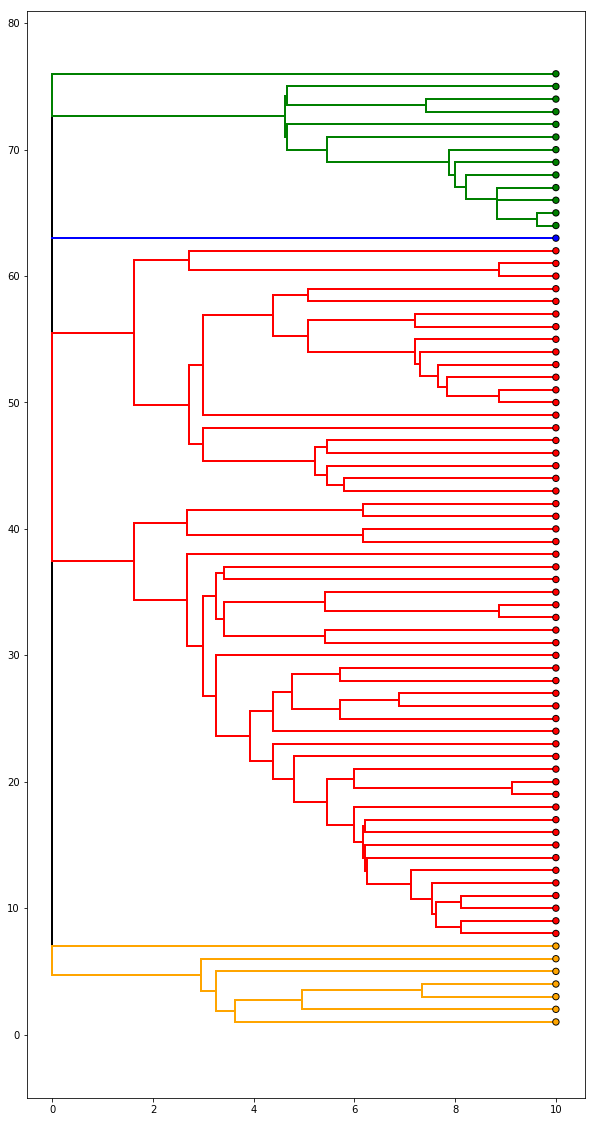

In [312]:
tree_CC.traverse_tree()
tree_CC.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree_CC.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultationtree.png')
plt.show()

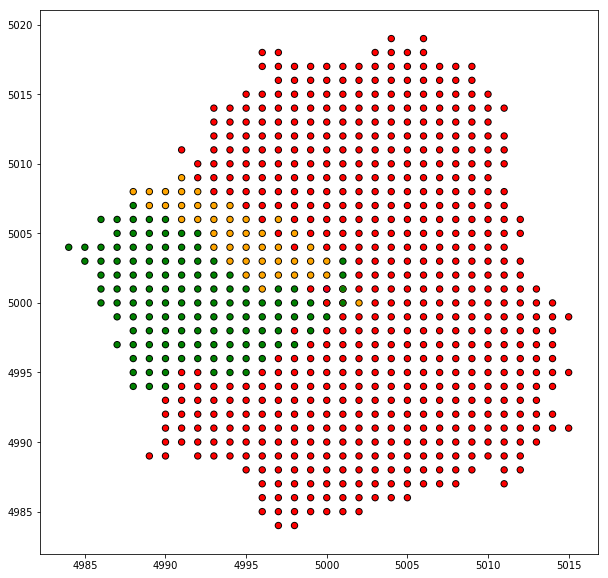

In [311]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells_CC:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultation.png')
plt.show()

## w/ selection